<h1>Random Forests and Logistic Regression Model Implementation</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

<h3> Read in the data, store if dataframe

In [137]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

# Tidying up the data

Implementing consistent capitalization and replacing underscores  spaces with hyphens in the data.

In [138]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

<h3>Replacing gender with dummy variables for easier visualisation

In [139]:
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

<h3> Cap the outliers at a maximum bmi of 60

In [140]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h3>Preliminary work for binning

In [141]:
##max age of 82, max bin get be set accordingly 
print("The max value in age is : " + str(df['age'].max()))
print("Total number of nulls in age is: " + str(df['age'].isnull().sum())) ##check for null
print("Total number of NAs in age is : " + str(df['age'].isna().sum())) ##check for NAs

The max value in age is : 82.0
Total number of nulls in age is: 0
Total number of NAs in age is : 0


<h3>Unknown_smoking status breakdown

In [142]:
##loop to find the number of unknown smoking entries
unknown_count = 0
##store the indexes of the unknown smoking status entries in case it's needed later
unknown_indexes = []
for index, i in enumerate(df['smoking_status']):
    if(i.lower() == 'unknown'):
        #get index and value 
        #print(index, i)
        unknown_indexes.append(index)
        unknown_count+=1
##get percentage of unknown
unknown_percent = unknown_count/len(df) * 100
unknown_percent = round(unknown_percent,4)
print("\nThe percent of entries with an unknown smoking status is: " + str(unknown_percent) + "% or " +str(unknown_count) + " entries")


The percent of entries with an unknown smoking status is: 30.2153% or 1544 entries


<h3>Checking for non-binary values</h3>
<P>Checked in heart_disease, hypertension, ever_married and stroke. Also converts ever_married to 0/1 instead of yes/no<P>

In [143]:
##check for any non-binary values in heart_disease
non_bin_heart_count = 0
for val in df['heart_disease']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_heart_count == 0):
    print("No non-binary values found in heart_disease")

##check for any non-binary values in hypertension
non_bin_hypt_count = 0
for val in df['hypertension']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_hypt_count == 0):
    print("No non-binary values found in hypertension")
    
##converts ever_married to 0/1 if not already done 
if(isinstance(df['ever_married'][0],str)):
    df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##checks for non-binary values in ever_married
non_bin_married_count = 0
for val in df['ever_married']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_married_count == 0):
    print("No non-binary values found in ever_married")
    
##check for any non-binary values in stroke
non_bin_stroke_count = 0
for val in df['stroke']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_stroke_count == 0):
    print("No non-binary values found in stroke")

No non-binary values found in heart_disease
No non-binary values found in hypertension
No non-binary values found in ever_married
No non-binary values found in stroke


### Impute missing BMI values
<P>Replace missing BMI values with the average BMI found in rows with the same age and gender<P>

#### Check initial number of nulls

In [144]:
##get number of nulls in df
df.isnull().sum()

id                     0
gender                 1
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  218
smoking_status         0
stroke                 0
dtype: int64

<h3>Impute missing values 

In [145]:
df['bmi_raw'] = df['bmi']

df['age'] = df['age'].apply(lambda x : round(x))

m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]


<h3>Checking again for nulls to verify imputation success</h3>
<p>NOTE: the values with nulls were left in a separate column in case it is needed later

In [146]:
df.isnull().sum()

id                     0
gender                 1
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
bmi_raw              218
dtype: int64

In [147]:
df.isnull().sum()

id                     0
gender                 1
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
bmi_raw              218
dtype: int64

In [148]:
df['gender'] = df['gender'].replace(np.nan, 0)

In [149]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
bmi_raw              218
dtype: int64

In [150]:
##I realised that gender had all been mapped to float, so I've fixed that he
df['gender'] = df['gender'].astype(int)

In [151]:
df2 = df.drop(['id','work_type','residence_type','smoking_status','bmi_raw'],axis=1)

In [152]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
0,1,67,0,1,1,228.69,36.6,1
1,0,61,0,0,1,202.21,29.1,1
2,1,80,0,1,1,105.92,32.5,1
3,0,49,0,0,1,171.23,34.4,1
4,0,79,1,0,1,174.12,24.0,1


# Modelling

## Training processing

Stratified kfold method with SMOTE oversampling

In [153]:
skf = StratifiedKFold(shuffle=True, n_splits=10)
def run_skfold(model, X, y):
    split = 0
    accuracy = []
    recall = []
    precision = []
    f1 = []
    roc_auc = []
    false_negative = []
    false_positive = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train_split, X_test_split = X.iloc[train_idx.tolist()], X.iloc[test_idx.tolist()]
        y_train_split, y_test_split = y.iloc[train_idx.tolist()], y.iloc[test_idx.tolist()]
        
        X_train_res, y_train_res = SMOTE().fit_resample(X_train_split, y_train_split)
        
        model.fit(X_train_res, y_train_res)
        y_pred_split = model.predict(X_test_split)
        y_prob_split = model.predict_proba(X_test_split)[:,1]
        
        print("Experiment:", split)
        
        print("Classification Report")
        print(classification_report(y_test_split, y_pred_split))
        
        print("Confusion Matrix")
        cm = confusion_matrix(y_test_split, y_pred_split)
        
        print(f"True postive: {cm[0][0]}")
        print(f"True negative: {cm[1][1]}")
        print(f"False postive: {cm[0][1]}")
        print(f"False negative: {cm[1][0]}")
        print("\n")
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_split, y_prob_split)
        
        report = classification_report(y_test_split, y_pred_split, output_dict=True)
        
        accuracy.append(report['accuracy'])
        recall.append(report['macro avg']['recall'])
        precision.append(report['macro avg']['precision'])
        f1.append(report['macro avg']['f1-score'])
        roc_auc.append(auc(false_positive_rate, true_positive_rate))
        false_negative.append(cm[1][0])
        false_positive.append(cm[0][1])
        
        split += 1
    
    print("Mean test results:")
    print(f"Mean accuracy: {round(np.mean(accuracy), 2)}")
    print(f"Mean macro avg recall: {round(np.mean(recall), 2)}")
    print(f"Mean macro avg precision: {round(np.mean(precision), 2)}")
    print(f"Mean macro avg f1: {round(np.mean(f1), 2)}")
    print(f"Mean ROC AUC: {round(np.mean(roc_auc), 2)}")
    print(f"Mean false negative: {round(np.mean(false_negative), 2)}")
    print(f"Mean false positive: {round(np.mean(false_positive), 2)}")
    
    # Raw data for comparison
    #print(f"Accuracy: {accuracy}")
    #print(f"Recall: {recall}")
    #print(f"Precision: {precision}")
    #print(f"F1: {f1}")
    #print(f"ROC AUC: {roc_auc}")
    #print(f"False negative: {false_negative}")
    #print(f"False positive: {false_positive}")
    


## Random Forest

The major issue with random forest is the balancing accuracy and recall, this can be improved by using stratified k fold cross validation 

### Setting up df for Random Forests

In [154]:
y = df2['stroke']
X = df2.drop('stroke',axis=1)

# Lower test splits (more training) seems to provide better recall
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Fix the balancing issues by using oversampling techniques
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

### Running the RF classifier

In [155]:
# Max depth of 5 seems to give the best recall
rf = RandomForestClassifier(random_state=5, max_depth=5, n_estimators=100, bootstrap=False)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

### Classification report for RF

In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       970
           1       0.12      0.71      0.20        52

    accuracy                           0.71      1022
   macro avg       0.55      0.71      0.51      1022
weighted avg       0.93      0.71      0.79      1022



### RF with stratified k-folds and scores

In [157]:
rf = RandomForestClassifier(random_state=5, max_depth=5, n_estimators=100, bootstrap=False)
skf = StratifiedKFold(shuffle=True, n_splits=10)
scores = cross_val_score(rf, X_train_res, y_train_res, cv=skf)

print('Cross-validation scores with 10 folds:')
print('')
print(f'Scores:\n{scores}')
print('')
print(f'accuracy: {round(np.mean(scores), 4)}')
print(f"ROC AUC: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='f1').mean(), 2)}")

Cross-validation scores with 10 folds:

Scores:
[0.8279846  0.81129653 0.83033419 0.81748072 0.82005141 0.8496144
 0.82262211 0.8470437  0.8277635  0.82390746]

accuracy: 0.8278
ROC AUC: 0.908
precision: 0.77
recall: 0.94
f1: 0.85


### Accuracy

Accuracy:  0.7113502935420744


<AxesSubplot:>

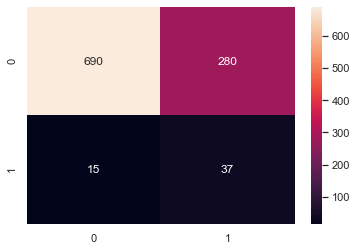

In [158]:
ac = accuracy_score(y_test, y_pred)
print('Accuracy: ', ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm , annot=True, fmt="d")

## Graphing AUC for RF

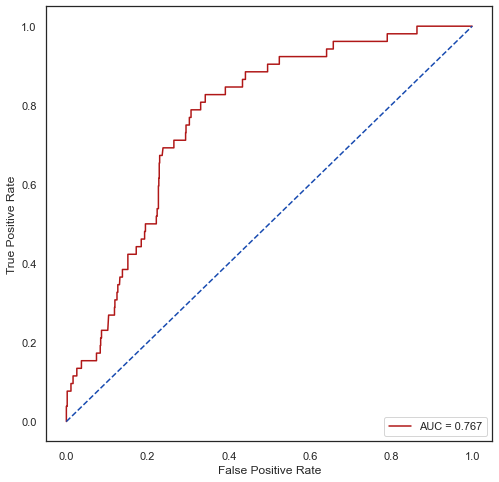

In [159]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate, true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [160]:
run_skfold(rf, X, y)

Experiment: 0
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       486
           1       0.13      0.80      0.23        25

    accuracy                           0.74       511
   macro avg       0.56      0.77      0.54       511
weighted avg       0.94      0.74      0.81       511

Confusion Matrix
True postive: 357
True negative: 20
False postive: 129
False negative: 5


Experiment: 1
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       486
           1       0.10      0.72      0.18        25

    accuracy                           0.68       511
   macro avg       0.54      0.70      0.49       511
weighted avg       0.94      0.68      0.77       511

Confusion Matrix
True postive: 331
True negative: 18
False postive: 155
False negative: 7


Experiment: 2
Classification Report
              precision    recall  f1-score   support


## Logistic Regression

### Setting up DF for Logistic Regression

In [161]:
y = df2['stroke']
X = df2.drop('stroke',axis=1)

# Lower test splits (more training) seems to provide better recall
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Fix the balancing issues by using oversampling techniques
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

### Running logistic regression

In [162]:
lr = LogisticRegression(random_state=5, max_iter=1000)
lr.fit(X_train_res, y_train_res)
#lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]

### Classification report for logistic regression

In [163]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       970
           1       0.13      0.62      0.21        52

    accuracy                           0.76      1022
   macro avg       0.55      0.69      0.54      1022
weighted avg       0.93      0.76      0.83      1022



## Logistic regression with stratified k folds and scores

In [164]:
skf = StratifiedKFold(shuffle=True, n_splits=5)
scores = cross_val_score(lr, X_train_res, y_train_res, cv=skf)

print('Cross-validation scores with 10 folds:')
print('')
print(f'Scores:\n{scores}')
print('')
print(f'accuracy: {round(np.mean(scores), 4)}')
print(f"ROC AUC: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='f1').mean(), 2)}")

Cross-validation scores with 10 folds:

Scores:
[0.78163134 0.77713552 0.781491   0.79113111 0.78984576]

accuracy: 0.7842
ROC AUC: 0.874
precision: 0.78
recall: 0.79
f1: 0.79


Accuracy:  0.764187866927593


<AxesSubplot:>

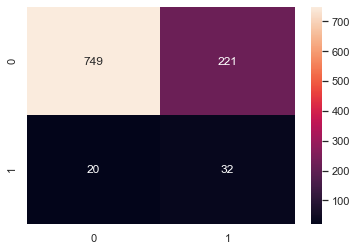

In [165]:
ac = accuracy_score(y_test, y_pred)
print('Accuracy: ', ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm , annot=True, fmt="d")

## Graphing AUC for logistic regression

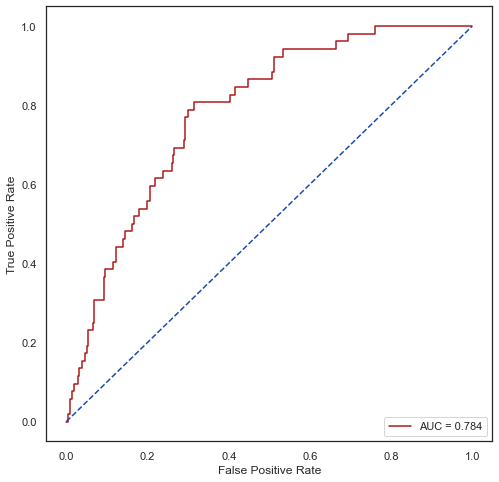

In [166]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate, true_positive_rate, color='#b01717', label='AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [167]:
run_skfold(lr, X, y)

Experiment: 0
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       972
           1       0.14      0.68      0.23        50

    accuracy                           0.78      1022
   macro avg       0.56      0.73      0.55      1022
weighted avg       0.94      0.78      0.84      1022

Confusion Matrix
True postive: 765
True negative: 34
False postive: 207
False negative: 16


Experiment: 1
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.12      0.62      0.20        50

    accuracy                           0.76      1022
   macro avg       0.55      0.69      0.53      1022
weighted avg       0.93      0.76      0.83      1022

Confusion Matrix
True postive: 746
True negative: 31
False postive: 226
False negative: 19


Experiment: 2
Classification Report
              precision    recall  f1-score   suppor